In [16]:
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D # type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
from sklearn.preprocessing import LabelEncoder


In [17]:

with open('intents.json') as file:
    data=json.load(file)

sample_sentences=[]
sample_labels=[]
labels=[]
responses=[]

for sentence in data['intents']:
    for q in sentence['questions']:
        sample_sentences.append(q)
        sample_labels.append(sentence['tag'])
    responses.append(sentence['responses'])
    if sentence['tag'] not in labels:
        labels.append(sentence['tag'])

num_classes=len(labels)

# conversion into model understandable form
label_encoder=LabelEncoder()
label_encoder.fit(sample_labels)
sample_labels=label_encoder.transform(sample_labels)


# oov replaces out of the vocabulary words with a special token
tokenizer=Tokenizer(num_words=1000,oov_token="<OOV>") # create a vocabulary with limited words
tokenizer.fit_on_texts(sample_sentences) # update vocabulary based on sentences
word_index=tokenizer.word_index # words indexes in vocabulary
sequences=tokenizer.texts_to_sequences(sample_sentences) # transform texts into sequences of integers

# transform list of integers into a 2D numpy array (num_samples, num_timesteps)
max_padding = 20 # max len of all sequences that others will be 'cut' to
padded_sequences=pad_sequences(sequences, truncating='post', maxlen=max_padding)

# neural network
model=Sequential()
max_input = 1000
emb_dim = 16
model.add(Embedding(max_input, emb_dim, input_length=max_padding)) # turn positive indexes into a dense vectors of fixed size
model.add(GlobalAveragePooling1D()) # create fixed-length vector for each example by averaging on the sequence dim
model.add(Dense(16, activation='relu')) # implement the activation operation on the input and give an output of length 16
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='softmax')) # output layer with a result of length of labels (categories)

# stochastic gradient descent for large models (adam), loss function for more than two labels
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()


Epoch 1/400


1/1 [==============================] - 1s 1s/step - loss: 1.9451 - accuracy: 0.2857
Epoch 2/400
1/1 [==============================] - 0s 18ms/step - loss: 1.9436 - accuracy: 0.1786
Epoch 3/400
1/1 [==============================] - 0s 17ms/step - loss: 1.9423 - accuracy: 0.1786
Epoch 4/400
1/1 [==============================] - 0s 13ms/step - loss: 1.9410 - accuracy: 0.1786
Epoch 5/400
1/1 [==============================] - 0s 13ms/step - loss: 1.9398 - accuracy: 0.2500
Epoch 6/400
1/1 [==============================] - 0s 16ms/step - loss: 1.9385 - accuracy: 0.3571
Epoch 7/400
1/1 [==============================] - 0s 9ms/step - loss: 1.9373 - accuracy: 0.2500
Epoch 8/400
1/1 [==============================] - 0s 17ms/step - loss: 1.9360 - accuracy: 0.2500
Epoch 9/400
1/1 [==============================] - 0s 22ms/step - loss: 1.9348 - accuracy: 0.2500
Epoch 10/400
1/1 [==============================] - 0s 10ms/step - loss: 1.9335 - accuracy: 0.2500
Epoch 11/400
1/1 [================

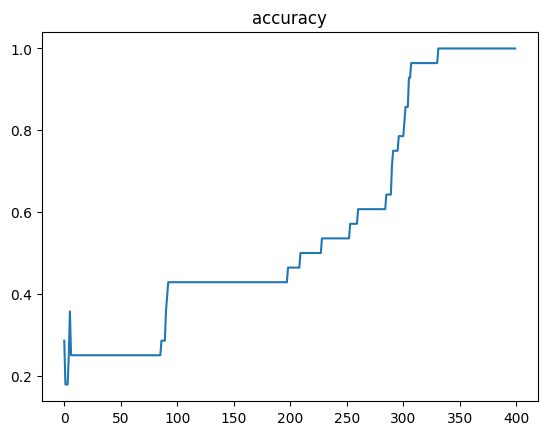

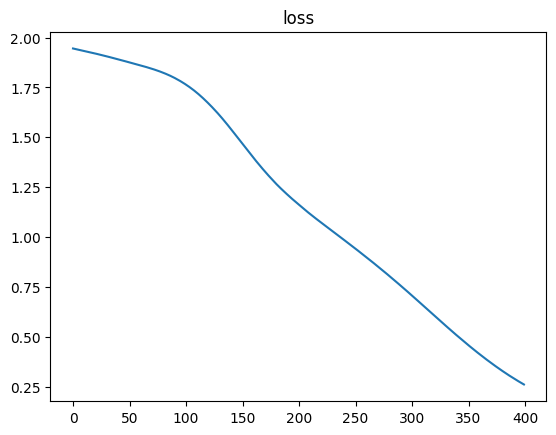

INFO:tensorflow:Assets written to: bot_model\assets


INFO:tensorflow:Assets written to: bot_model\assets


In [18]:
import matplotlib.pyplot as plt # type: ignore
# training the model
num_epochs = 400
hist=model.fit(padded_sequences, np.array(sample_labels), epochs=num_epochs)

# plot
plt.plot(hist.history['accuracy'])
plt.title('accuracy')
plt.show()
plt.plot(hist.history['loss'])
plt.title('loss')
plt.show()

# save the model
model.save("bot_model")
# save the tokenizer and encoder
import pickle
with open('tokenizer.pickle', 'wb') as token:
    pickle.dump(tokenizer, token, protocol=pickle.HIGHEST_PROTOCOL)
with open('label_encoder.pickle', 'wb') as enc:
    pickle.dump(label_encoder, enc, protocol=pickle.HIGHEST_PROTOCOL)